# Section 11 - Style Transfer - PyTorch

# PyTorch Instalation

In [0]:
!pip install torch torchvision
!pip install Pillow==4.0.0

     |████████████████████████████████| 2.1MB 2.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.4.2 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


# Importing needed libraries

In [0]:
%matplotlib inline 
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Importing features from pre-trained model VGG19

In [0]:
vgg = models.vgg19(pretrained=True).features

# This maintain the parameters constant and the parameters are unaffected by the backpropagation process that normaly updates this weights.
# This freeze the features layer, in this case, the weight of the filters on convolution layers will not be updated.
for param in vgg.parameters():
    param.requires_grad_(False)

## Initializing GPU Usage

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device) # Alocating the VGG model to the GPU.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Making and Configuring the dataset

> ## ***For Style Transfer is very important that the size of the content image be the same that the size of the style image.***

In [0]:
# This function control the size of images.
# max_size: Control the size of images(width and height) used in the process
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB') # Setting the color space of the imported image. 
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0)
    
    return image


In [0]:
content = load_image('City.jpg').to(device) # Loading the content image and alocating it to the GPU
style = load_image('StarryNight.jpg').to(device) # Loading the style image and alocating it to the GPU

In [0]:
# This function convert the images from tensor to numpy image.
# This allow the visualization of images.
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

(-0.5, 615.5, 399.5, -0.5)

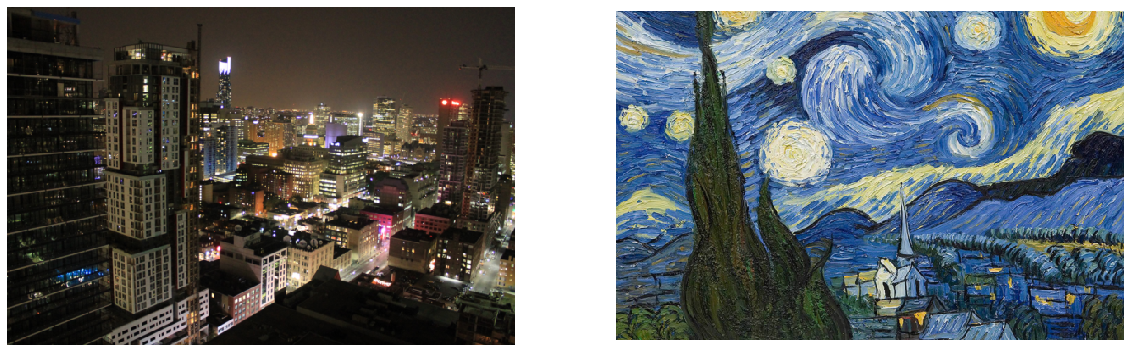

In [0]:
# Plot of content and style images loaded.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [0]:
# This function will extract features from vgg model prematurely from some Feature Layers.
# These features can be "content" from content image or "style" from style image.
# The layers were chosen based on Style Transfer Paper.
# Five layers for style extraction were used instead of one because it's easier to extract and reconstruct style from five layers instead of one. 

def get_features(image, model):
   
    layers = {'0': 'conv1_1',       # Style Extraction
              '5': 'conv2_1',       # Style Extraction
              '10': 'conv3_1',      # Style Extraction 
              '19': 'conv4_1',      # Style Extraction
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}      # Style Extraction
        
    features = {}

    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [0]:
# Calling the get_features function to extract features from content and style images.
# The variables 'content_features' and 'style_features' will store the features dictionary extracted from content and style images.

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
# Gram Matrix is: V * (transpose(V))
# This matrix is used to eliminate the content features from features dictionary.

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta


In [0]:
# The target image at the beginning is a white noise image that is optmized during the process until results on the content image with style.
# In this implementation, the target image is a clone of content image.

target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300 # Show the target image every so often, so the progress of the optimization process can be checked.
optimizer = optim.Adam([target], lr=0.003)
steps = 2100 # Steps for the optimization process.

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

Total loss:  3143854.0
Iteration:  300


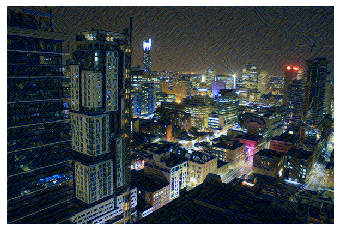

Total loss:  1026111.625
Iteration:  600


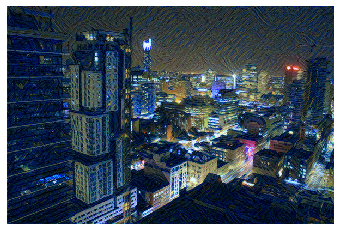

Total loss:  699927.5625
Iteration:  900


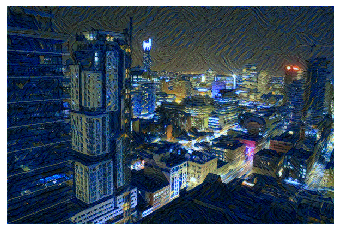

Total loss:  542216.625
Iteration:  1200


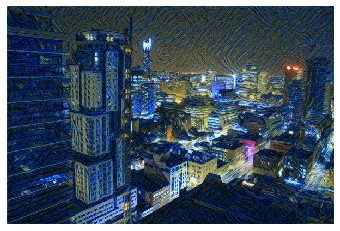

Total loss:  426310.375
Iteration:  1500


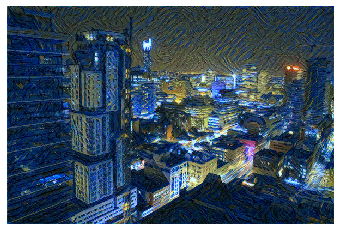

Total loss:  335926.625
Iteration:  1800


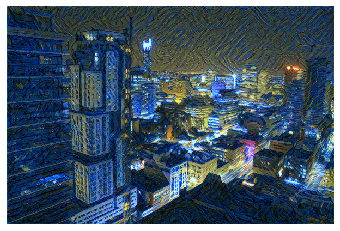

Total loss:  264132.59375
Iteration:  2100


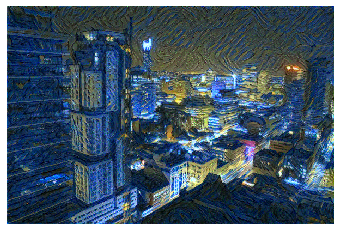

In [0]:
for ii in range(1, steps+1): # Run through the steps.
  target_features = get_features(target, vgg) # Returns the features dictionary from target(clone of content image) image.
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2) # Loss between target's content features and content's content features.
  style_loss = 0
  
  for layer in style_weights: # Run through the style_weights dictionary. The loss is calculated for every layer in style_weights.
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

(-0.5, 599.5, 399.5, -0.5)

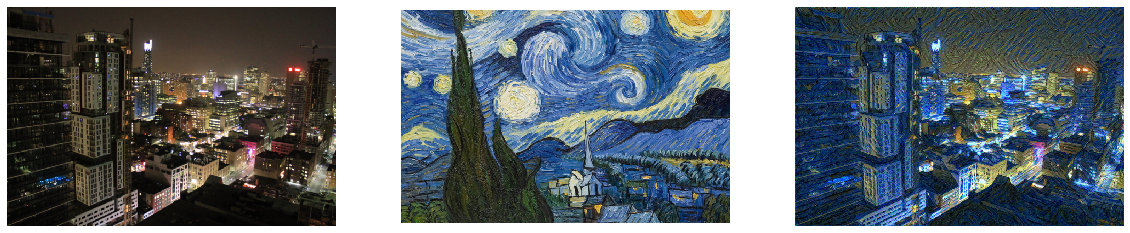

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [0]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [0]:
!ls

City.jpg  MonaLisa.jpg	output.mp4  sample_data  StarryNight.jpg


In [0]:
from google.colab import files
files.download('output.mp4')